# 📢 File explanation!!
Di dalam file ini, saya akan meembuat model menggunakan CNN

# 🎯 **Step 0: Import library**
---

In [1]:
# import gradio as gr
# import numpy as np
# import evaluate


# from datasets import load_dataset, Audio
# from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import keras
import tensorflow as tf
import seaborn as sns


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from IPython.display import Audio

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adam


# 🎯 **Step 1: Load dataset**
---

In [2]:
df_voice = pd.read_csv('./Dataset/df_combined.csv')

df_voice.head()

,Path,Emotion
0,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,neutral
1,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,neutral
2,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,neutral
3,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,neutral
4,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,calm


In [3]:
df_voice['Emotion'].value_counts()

Emotion
happy        752
sad          752
angry        752
neutral      716
fearful      652
disgust      652
surprised    652
calm         192
Name: count, dtype: int64

In [4]:
df_voice = df_voice[df_voice['Emotion'] != 'calm']
df_voice = df_voice[df_voice['Emotion'] != 'fearful'] # = angry
df_voice = df_voice[df_voice['Emotion'] != 'disgust'] # 
df_voice = df_voice[df_voice['Emotion'] != 'surprised'] # = happy

In [5]:
df_voice['Emotion'].value_counts()

Emotion
happy      752
sad        752
angry      752
neutral    716
Name: count, dtype: int64

In [6]:
path = np.array(df_voice.Path)[100]
data, sample_rate = librosa.load(path)

sample_rate

22050

# 🎯 **Step 2: Data augmentation**
---

🔎 Pada step ini, saya tambahkan variasi pada setiap rekaman audio untuk memperkaya fitur-fitur yang diekstraksi.

In [7]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def time_shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch_change(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=0.8)

def higher_speed(data):
    return librosa.effects.time_stretch(y=data, rate=1.25)

def lower_speed(data):
    return librosa.effects.time_stretch(y=data, rate=0.75)

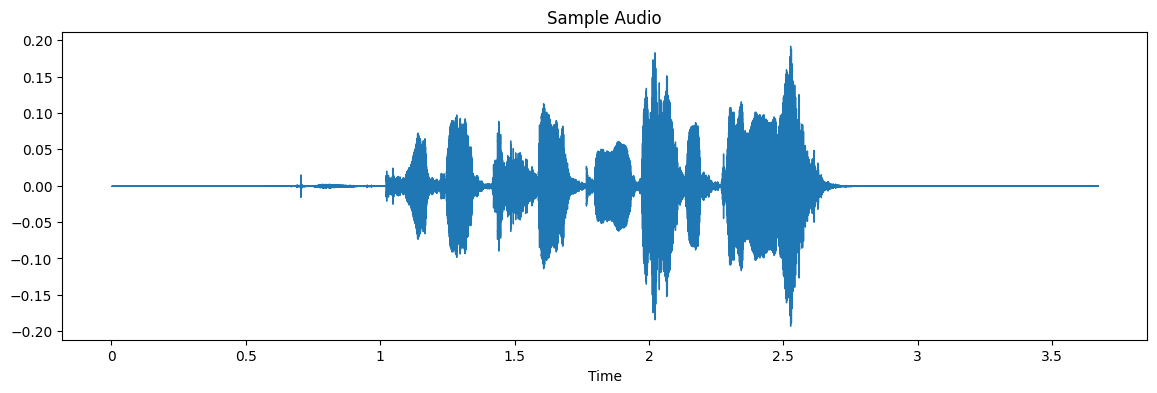

In [8]:
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=data, sr=sample_rate)
display(Audio(path))

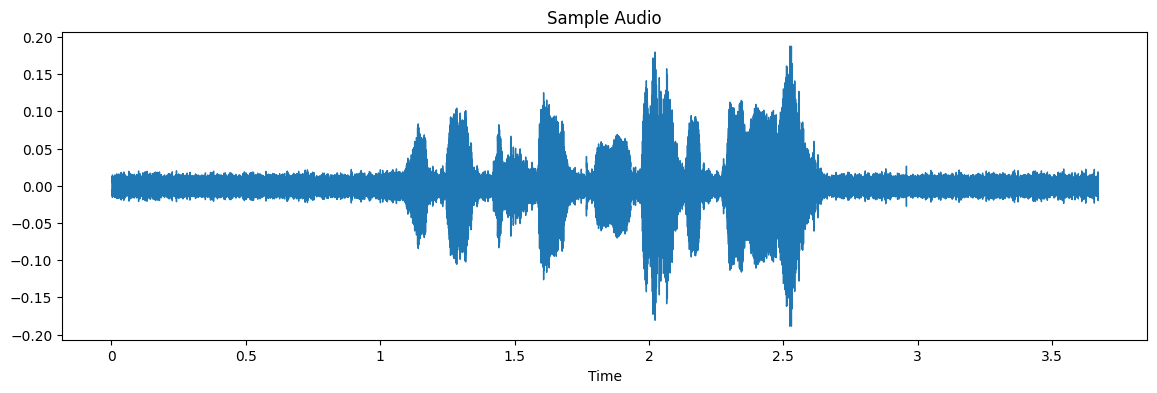

In [9]:
x = noise(data)
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
display(Audio(path))

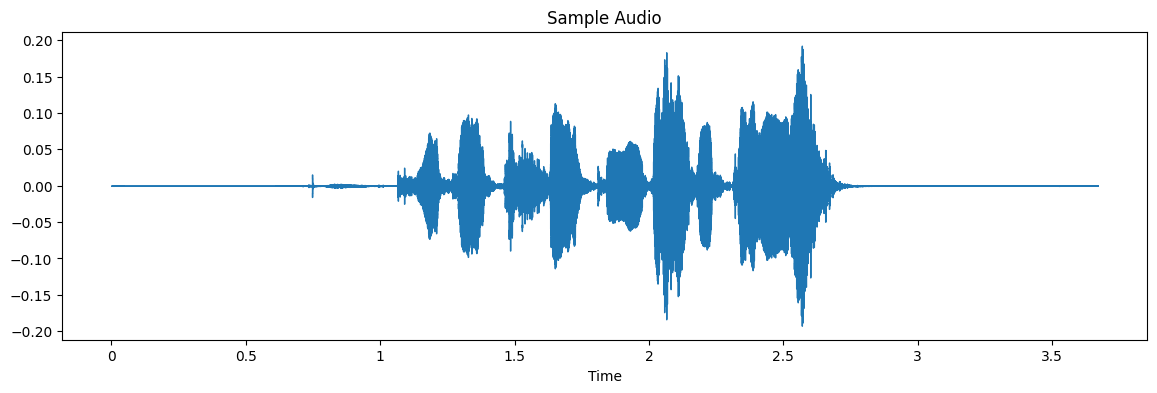

In [10]:
x = time_shift(data)
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
display(Audio(path))

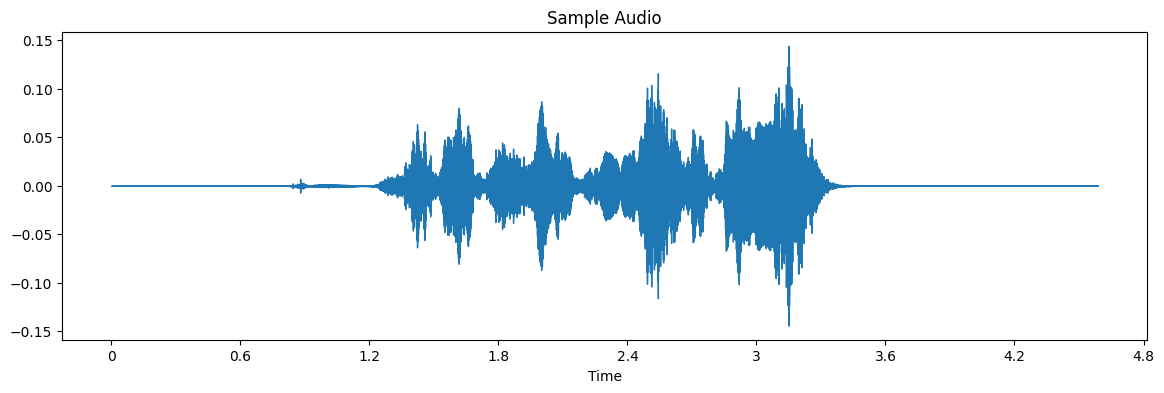

In [11]:
x = stretch(data)
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
display(Audio(path))

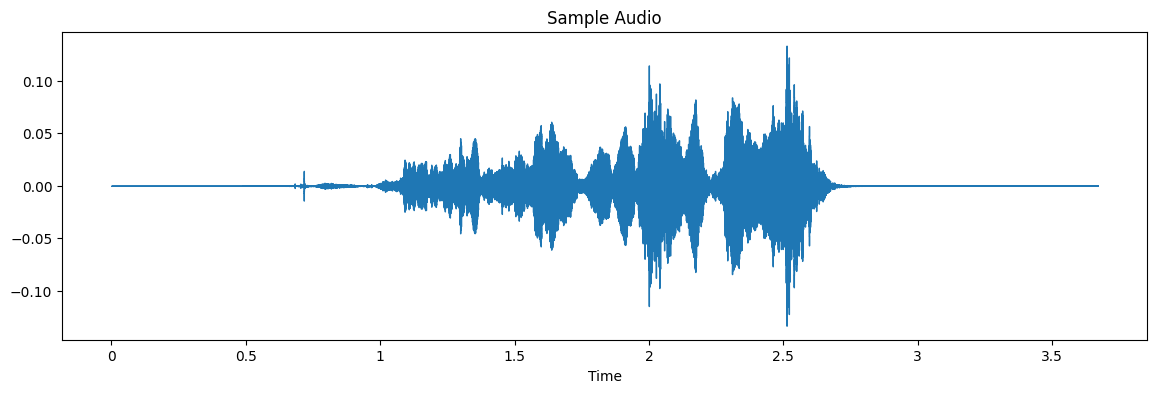

In [12]:
x = pitch_change(data, sample_rate)
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
display(Audio(path))

# 🎯 **Step 2: Feature extraction**
---

In [13]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [14]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    timeshift_data = time_shift(data)
    res3 = extract_features(timeshift_data)
    result = np.vstack((result, res3))

    speedchange_data = stretch(data)
    res4 = extract_features(speedchange_data)
    result = np.vstack((result, res4))

    pitchchange_data = pitch_change(data, sample_rate)
    res5 = extract_features(pitchchange_data)
    result = np.vstack((result, res5))

    highspeed_data = higher_speed(data)
    res6 = extract_features(highspeed_data)
    result = np.vstack((result, res6))

    lowerspeed_data = lower_speed(data)
    res7 = extract_features(lowerspeed_data)
    result = np.vstack((result, res7))
    
    return result

In [15]:
X, Y = [], []
for path, emotion in zip(df_voice.Path, df_voice.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [17]:
len(X), len(Y), df_voice.Path.shape

(481464, 481464, (2972,))

In [19]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('./Features/only_extract_features.csv', index=False)
Features

,0,labels
0,0.321275,neutral
1,0.729664,neutral
2,0.750033,neutral
3,0.730624,neutral
4,0.735275,neutral
...,...,...
481459,0.006037,sad
481460,0.004118,sad
481461,0.002662,sad
481462,0.001036,sad


# 🎯 **Step 3: Split data into feature and label**
---

In [20]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# 🎯 **Step 4: Convert labels to number**
---

In [21]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# 🎯 **Step 5: Split data into train and test**
---

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((385171, 1), (385171, 4), (96293, 1), (96293, 4))

# 🎯 **Step 6: Equalize the data range**
---

🔎 Pada step ini, dilakukan penyamaan range data karena bisa dilihat pada hasil ekstraksi fitur range antar data berjauhan

In [23]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((385171, 1), (385171, 4), (96293, 1), (96293, 4))

# 🎯 **Step 7: Add dimension**
---

In [24]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((385171, 1, 1), (385171, 4), (96293, 1, 1), (96293, 4))

# 🎯 **Step 8: Create model**
---

In [25]:
def model(x_train):
    model=Sequential()
    model.add(Conv1D(512, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))
    
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=4, strides = 2, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=4, activation='softmax'))

    opt = Adam(lr = 0.0001)
    model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [26]:
model = model(x_train)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 512)            3584      
                                                                 
 average_pooling1d (Average  (None, 1, 512)            0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 256)            786688    
                                                                 
 average_pooling1d_1 (Avera  (None, 1, 256)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            196736    
                                                                 
 average_pooling1d_2 (Avera  (None, 1, 128)            0

In [27]:
result_path = './Result'

class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96):
            print("\nReached 99% accuracy") 
            self.model.stop_training = True 
     
callbacks = Callback()

checkpoint = tf.keras.callbacks.ModelCheckpoint(result_path + f'/only_extract_features.h5', 
        monitor='val_accuracy', verbose=1, 
        save_best_only=True, mode='max')

# 🎯 **Step 9: Training model**
---

In [28]:
epoch = 50
history=model.fit(x_train, y_train, 
                  batch_size=32, epochs=epoch,
#                   steps_per_epoch=50,
                  validation_data=(x_test, y_test), callbacks=[callbacks, checkpoint])

Epoch 1/50



12037/12037 [==============================] - ETA: 0s - loss: 1.3862 - accuracy: 0.2523
Epoch 1: val_accuracy improved from -inf to 0.25171, saving model to ./Result\only_extract_features.h5


c:\Users\LENOVO YOGA\Music\FINAL PROJECT\finalproject\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12037/12037 [==============================] - 402s 33ms/step - loss: 1.3862 - accuracy: 0.2523 - val_loss: 1.3863 - val_accuracy: 0.2517
Epoch 2/50
12037/12037 [==============================] - ETA: 0s - loss: 1.3861 - accuracy: 0.2517
Epoch 2: val_accuracy improved from 0.25171 to 0.25367, saving model to ./Result\only_extract_features.h5
12037/12037 [==============================] - 345s 29ms/step - loss: 1.3861 - accuracy: 0.2517 - val_loss: 1.3862 - val_accuracy: 0.2537
Epoch 3/50
12035/12037 [============================>.] - ETA: 0s - loss: 1.3861 - accuracy: 0.2535
Epoch 3: val_accuracy did not improve from 0.25367
12037/12037 [==============================] - 411s 34ms/step - loss: 1.3861 - accuracy: 0.2535 - val_loss: 1.3863 - val_accuracy: 0.2517
Epoch 4/50
12035/12037 [============================>.] - ETA: 0s - loss: 1.3861 - accuracy: 0.2529
Epoch 4: val_accuracy did not improve from 0.25367
12037/12037 [==============================] - 361s 30ms/step - loss: 1.3861 -

KeyboardInterrupt: 

# 🎯 **Step 10: Evaluation**
---

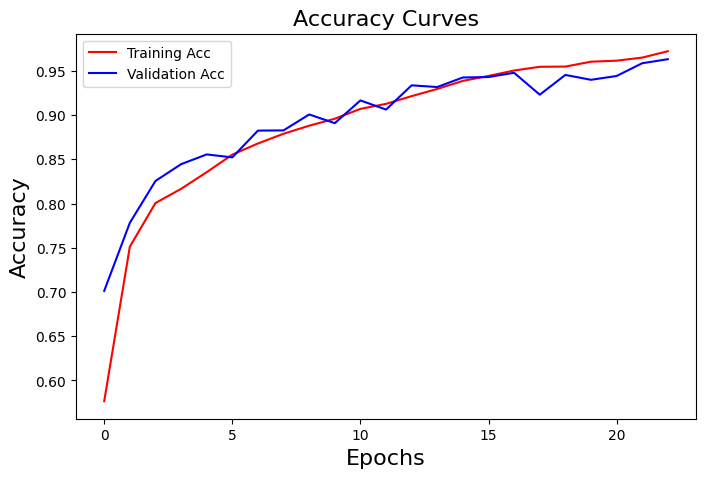

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend(['Training Acc', 'Validation Acc'])
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

plt.show()

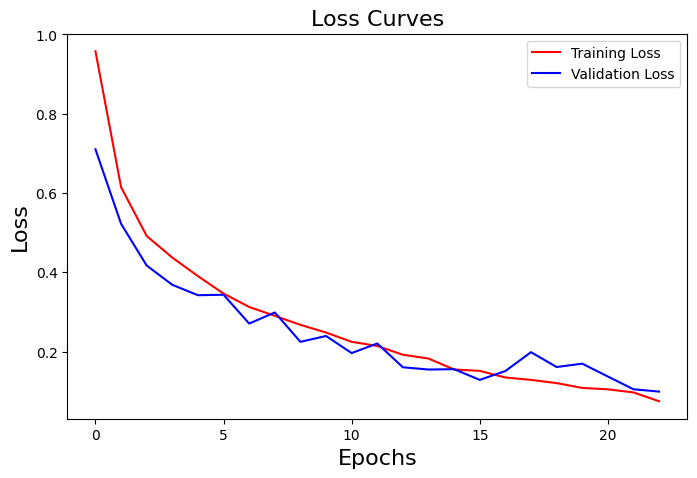

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)

plt.show()

In [ ]:
# from tensorflow.keras.models import load_model

# # Ganti 'nama_model.h5' dengan nama file H5 yang Anda simpan
# model = load_model('./Result/best_model_without_calm_512.h5')

# # Sekarang model sudah dimuat dan siap digunakan untuk prediksi atau evaluasi


In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_actual = encoder.inverse_transform(y_test)

131/131 [==============================] - 6s 42ms/step


In [ ]:
df_pred_vs_actual = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_pred_vs_actual['Predicted Labels'] = y_pred.flatten()
df_pred_vs_actual['Actual Labels'] = y_actual.flatten()

df_pred_vs_actual.head(15)

,Predicted Labels,Actual Labels
0,happy,happy
1,sad,sad
2,neutral,neutral
3,sad,sad
4,neutral,neutral
5,happy,happy
6,happy,happy
7,angry,happy
8,angry,angry
9,sad,sad


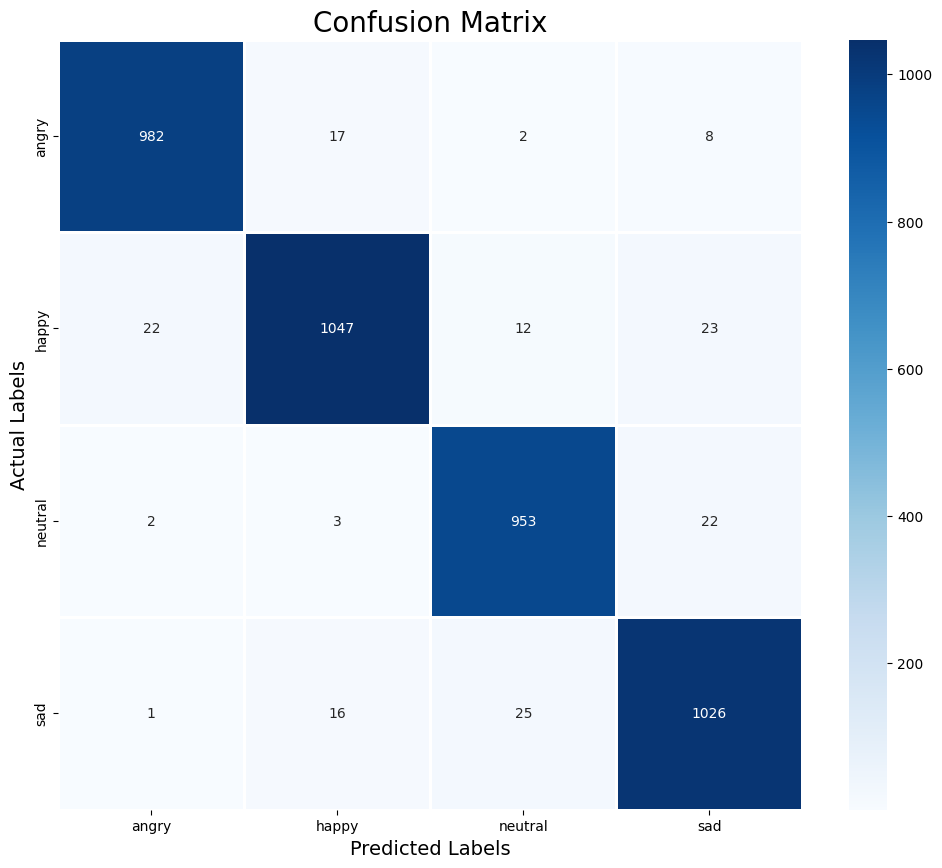

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
print(classification_report(y_actual, y_pred))

131/131 [==============================] - 6s 45ms/step - loss: 0.0989 - accuracy: 0.9632
Accuracy of our model on test data :  96.32300138473511 %
              precision    recall  f1-score   support

       angry       0.98      0.97      0.97      1009
       happy       0.97      0.95      0.96      1104
     neutral       0.96      0.97      0.97       980
         sad       0.95      0.96      0.96      1068

    accuracy                           0.96      4161
   macro avg       0.96      0.96      0.96      4161
weighted avg       0.96      0.96      0.96      4161



# 🎯 **Step 11: Inference the model**
---

In [ ]:
path = './Armin sees Eren’s head and cries Attack on Titan Final Season Part 3 Ep2.mp3'

feature_test = get_features(path)
test_input = []
for ele in feature_test:
    test_input.append(ele)
    
feat_test = pd.DataFrame(test_input)
test_X = feat_test.values
test_X = scaler.transform(test_X)
test_X = np.expand_dims(test_X, axis=2)

pred_sub = model.predict(test_X, batch_size = 32)
y_sub = encoder.inverse_transform(pred_sub)
classes = y_sub.flatten()[2]

print(classes)    

C:\Users\LENOVO YOGA\AppData\Local\Temp\ipykernel_10096\3698892235.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
c:\Users\LENOVO YOGA\Music\FINAL PROJECT\finalproject\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 70ms/step
sad


In [ ]:
import os

data_submission = []

path = './Dataset/Test/happiness'

file_list = os.listdir(path)

for audio_name in file_list:
    audio_test = os.path.join(path, audio_name)

    # print(audio_test)
    feature_test = get_features(audio_test)
    test_input = []
    for ele in feature_test:
        test_input.append(ele)
        
    feat_test = pd.DataFrame(test_input)
    test_X = feat_test.values
    test_X = scaler.transform(test_X)
    test_X = np.expand_dims(test_X, axis=2)
    
    pred_sub = model.predict(test_X, batch_size = 32)
    y_sub = encoder.inverse_transform(pred_sub)
    classes = y_sub.flatten()[2]
   
    print(audio_name, classes)    
    data_submission.append((audio_name,classes))

1/1 [==============================] - 0s 40ms/step
h01 (1).wav angry
1/1 [==============================] - 0s 38ms/step
h01 (2).wav happy
1/1 [==============================] - 0s 43ms/step
h01 (3).wav happy
1/1 [==============================] - 0s 44ms/step
h01 (4).wav happy
1/1 [==============================] - 0s 40ms/step
h01 (5).wav happy
1/1 [==============================] - 0s 35ms/step
h01 (6).wav neutral
1/1 [==============================] - 0s 47ms/step
h02 (1).wav happy
1/1 [==============================] - 0s 60ms/step
h02 (2).wav angry
1/1 [==============================] - 0s 78ms/step
h02 (3).wav angry
1/1 [==============================] - 0s 64ms/step
h02 (4).wav angry
1/1 [==============================] - 0s 153ms/step
h02 (5).wav angry
1/1 [==============================] - 0s 53ms/step
h02 (6).wav happy
1/1 [==============================] - 0s 43ms/step
h03 (1).wav happy
1/1 [==============================] - 0s 58ms/step
h03 (2).wav angry
1/1 [============

In [ ]:
col = ['id', 'value']
df_submission = pd.DataFrame(data_submission, columns=col)
df_submission['value'].value_counts()

value
angry      62
happy      33
sad        13
neutral    11
Name: count, dtype: int64